## This is a notebook to demonstrate basic usege of pyAPES (python Atmosphere-Plant Exchange Simulator; Launiainen et al., 2015)

In [1]:
%load_ext autoreload
# basic python tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### First case: SMEARII site without soil dynamics
This means that soil temperature and water content is given as a forcing.

Steps are

1. Get parameters and forcing for study sites
2. Wrap parameters and forcing in dictionary
3. Run the model


Simulation results are saved into netcdf-file, logging is saved in pyAPES.log, and driver-function returns file path to results of simulation and pyAPES model instance.

In [2]:
%autoreload
from parameters.SmearII import gpara, cpara, spara
from tools.iotools import read_forcing

from pyAPES import driver

forcing = read_forcing(
    forc_filename=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

# check forcing
print(forcing.columns)

params = {
    'general': gpara,
    'canopy': cpara,
    'soil': spara,
    'forcing': forcing
}

outputfile, Model = driver(parameters=params, create_ncf=True, result_file='demo_1.nc')


1.0 1.0
0.9999999999999998 1.0
1.0 1.0


INFO pyAPES driver Simulation started. Number of simulations: 1
INFO soil.water __init__ Water balance in soil not solved.
INFO soil.heat __init__ Heat balance in soil not solved.
INFO pyAPES __init__ Soil temperature from forcing file
INFO canopy.canopy __init__ Eflow: True, WMA: False, Ebal: True
INFO canopy.radiation __init__ Shortwave radiation model: ZHAOQUALLS
INFO canopy.radiation __init__ Longwave radiation model: ZHAOQUALLS
/Users/ajkieloaho/Repositories/pyAPES_VESBO/canopy/forestfloor/organiclayer.py:1169: RuntimeWarning: invalid value encountered in power
  Psi = -1e-2 / alfa*(s**(1.0 / m) - 1.0)**(1.0 / n)  # m
INFO canopy.forestfloor.forestfloor __init__ Forestfloor: litter, coverage 0.0 omitted!
INFO canopy.forestfloor.forestfloor __init__ Forestfloor: sphagnum, coverage 0.0 omitted!
INFO canopy.forestfloor.forestfloor __init__ Forestfloor has 1 bottomlayer types
INFO pyAPES driver Running simulation number (start time 2020-09-11 15:26): 0
INFO pyAPES run Running simulati

Index(['doy', 'Prec', 'P', 'Tair', 'Tdaily', 'U', 'Ustar', 'H2O', 'CO2', 'Zen',
       'LWin', 'diffPar', 'dirPar', 'diffNir', 'dirNir', 'X', 'DDsum', 'Tsh',
       'Wh', 'Tsa', 'Ws', 'Rew'],
      dtype='object')
0%.. 10%.. 20%.. 30%.. 40%.. 50%.. 60%.. 70%.. 80%.. 90%.. 

INFO pyAPES run Finished simulation 0, running time 54.89 seconds
INFO pyAPES driver Running time 54.89 seconds
INFO pyAPES driver Ready! Results are in: results/Hyytiala/demo_1.nc


100%


#### Data tools

Now on, we just play with results and SMEAR II -data. This is all external to the model.

First, we read results from NetCDF-file to xarray-dataset (xarray documentation here: http://xarray.pydata.org/en/stable/index.html). 

Second, we read flux and metorological datafiles into pandas-dataframes (pandas documentation here: https://pandas.pydata.org/pandas-docs/stable/index.html).


In [3]:
from tools.iotools import read_results, read_data
results = read_results(outputfile)

flxdata = read_data("forcing/Hyytiala/FIHy_flx_2005-2010.dat", sep=';',
                       start_time=results.date[0].values, end_time=results.date[-1].values)
metdata = read_data("forcing/Hyytiala/FIHy_met_2005-2010.dat", sep=';',
                       start_time=results.date[0].values, end_time=results.date[-1].values)

In [4]:
print(results)

<xarray.Dataset>
Dimensions:                             (canopy: 101, date: 337, planttype: 4, simulation: 1, soil: 1)
Coordinates:
  * date                                (date) datetime64[ns] 2005-06-01 ... 2005-06-08
  * simulation                          (simulation) int64 0
Dimensions without coordinates: canopy, planttype, soil
Data variables:
    forcing_air_temperature             (date, simulation) float32 ...
    forcing_par                         (date, simulation) float32 ...
    forcing_nir                         (date, simulation) float32 ...
    canopy_LAI                          (date, simulation) float32 ...
    canopy_lad                          (date, simulation, canopy) float32 ...
    canopy_z                            (canopy) float32 ...
    canopy_h2o                          (date, simulation, canopy) float32 ...
    canopy_co2                          (date, simulation, canopy) float32 ...
    canopy_temperature                  (date, simulation, canop

Above there is a print of outputfile metadata. From the print you can see that data has following dimensions:

- date = time
- simulation, simulation number. If there is only one, remember that it has index 0!
- canopy, canopy layers. Index is 0 at ground and increases upwards
- planttype (planttypes),
- soil (nr soil layers, 0 at top)
- groundtype (groundtypes at forestfloor)

depending on data variable, the number of dimensions vary and dimensions for each variable have been listed in brackets after name of data variable.

Unlike other data variables canopy_planttypes and ffloor_groundtypes are object type! They don't contain numeric data. Each data variable have their own attribute containing a short description and unit.

In [5]:
print(results['canopy_NEE'].attrs)
print(results['pt_leaf_temperature'].attrs)

{'units': 'net ecosystem exchange [umol m-2 s-1]'}
{'units': 'leaf temperature mean [degC]'}


#### Plotting

Let's plot some variables!

First, some properties from results dataset and then we do some basic plotting.

Kersti has some more advanced codes in pyAPES_utilities.plotting

In [6]:
sim = 0  # we have only one simulation
# python indices start from 0, -1 refers to last element in array, : means 'all'
t = results.date  # time
zc = results.canopy_z  # height above ground [m]
zs = results.soil_z  # depth of soil; shown negative [m]

##### Canopy structure and planttypes
leaf-area density profile at end of simulation:
these are not yet realistic for SMEAR II.

Text(0.5, 1.0, 'canopy LAI = 4.2155123')

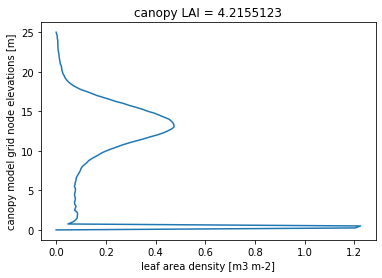

In [7]:
plt.figure('LAD')
var = 'canopy_lad'
plt.plot(results[var][-1, sim, :], zc)
plt.xlabel(results[var].attrs['units'])
plt.ylabel(zc.attrs['units'])
plt.title('canopy LAI = ' + (str(results['canopy_LAI'][-1, sim,].values)))

##### micromet.Micromet -submodel solves momentum exchange and scalar profiles in canopy air-space

Now, we plot ensemble flow profiles: compute time-averaged wind speed and u$^\star$ at each height

Text(0, 0.5, 'canopy model grid node elevations [m]')

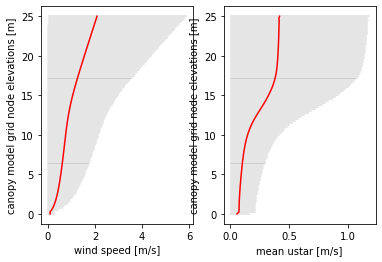

In [8]:
# matric of heights for fast plotting
zcm = np.ones(np.shape(results['canopy_wind_speed'][:, sim, :])) * zc.values

U = np.mean(results['canopy_wind_speed'][:, sim, :], axis=0)
ust = np.mean(results['canopy_friction_velocity'][:, sim, :], axis=0)

plt.figure('flow')

plt.subplot(121)
plt.plot(results['canopy_wind_speed'][:, sim, :], zcm, 'k', alpha=0.1)
plt.plot(U, zc, 'r-')
plt.xlabel('wind speed [m/s]')
plt.ylabel(zc.attrs['units'])

plt.subplot(122)
plt.plot(results['canopy_friction_velocity'][:, sim, :], zcm, 'k', alpha=0.1)
plt.plot(ust, zc, 'r-')
plt.xlabel('mean ustar [m/s]')
plt.ylabel(zc.attrs['units'])

Next we plot ensemble concentration profiles as difference to top layer; separately for day and night

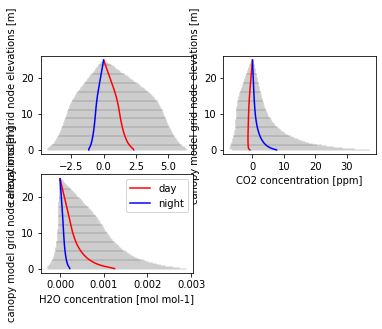

In [9]:
par = results['forcing_par'][:,sim] # use PAR as criteria for night / day

var = ['canopy_temperature', 'canopy_co2', 'canopy_h2o']

plt.figure('scalarprofiles')
n = 1
for v in var:
    plt.subplot(2,2,n)
    x = results[v][:, sim, :] - results[v][:, sim, -1] # s - s_ref
    xm = np.mean(x, axis=0)
    xmn = np.mean(x.loc[par < 20, :], axis=0) # night
    xmd = np.mean(x.loc[par > 200, :], axis=0) # day
    plt.plot(x, zcm, 'k', alpha=0.1)
    plt.plot(xmd, zc, 'r', label='day'); plt.plot(xmn, zc, 'b', label='night')
    plt.xlabel(results[v].attrs['units']); plt.ylabel(zc.attrs['units'])
    n += 1

plt.legend()


Below we have plotted timeseries of some micromet variables at above-canopy (forging) and in sub-canopy

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


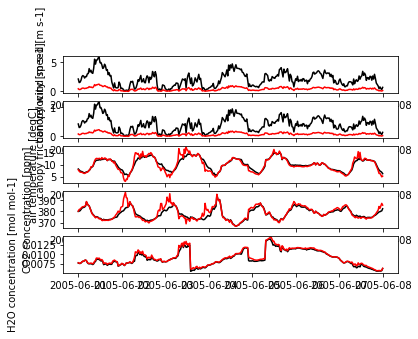

In [10]:
zsub = 3.0 # sub-canopy height [m], next find gridnode closest to this
ixsub = np.where((zc - zsub) == min(abs(zc - zsub)))[0]

plt.figure('micromet')
var = ['canopy_wind_speed', 'canopy_friction_velocity', 'canopy_temperature', 'canopy_co2', 'canopy_h2o']

n = 1
for v in var:
    plt.subplot(5,1,n)
    plt.plot(t, results[v][:, sim, -1], 'k-', label='ref')
    plt.plot(t, results[v][:, sim, ixsub], 'r-', label='sub')
    plt.ylabel(results[v].attrs['units'])
    n +=1

##### canopy.radiation.Radiation -model solves short-wave and long-wave radiation:

it provides profiles of incident downward, and upward radiation components [W m$^{-2}_{\mathrm{ground}}$] radiation absorbed per unit leaf area  [W m$^{-2}_{\mathrm{leaf}}$] at each layer, separately for sunlit and shaded factions of leaves.

Below, we plot first daytime short-wave profiles and timeseries above canopy


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0, 0.5, 'W m-2')

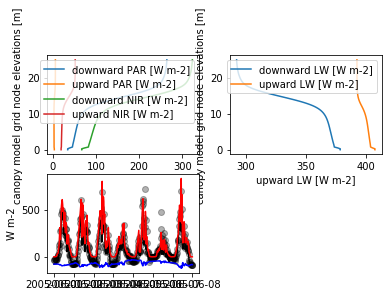

In [11]:
var = ['canopy_par_down', 'canopy_par_up', 'canopy_nir_down', 'canopy_nir_up']

plt.figure('shortwave')

for v in var:
    plt.subplot(2,2,1)
    x = results[v][:, sim, :]
    #xm = np.mean(x, axis=0)
    #xmn = np.mean(x.loc[par < 20, :], axis=0) # night
    xmd = np.mean(x.loc[par > 200, :], axis=0) # day
    #plt.plot(x, zcm, 'k', alpha=0.1)
    plt.plot(xmd, zc, '-', label=results[v].attrs['units'])
    plt.xlabel(results[v].attrs['units'])
    plt.ylabel(zc.attrs['units'])

plt.legend()

var = ['canopy_lw_down', 'canopy_lw_up']
for v in var:
    plt.subplot(2,2,2)
    x = results[v][:, sim, :]
    #xm = np.mean(x, axis=0)
    #xmn = np.mean(x.loc[par < 20, :], axis=0) # night
    xmd = np.mean(x.loc[par > 200, :], axis=0) # day
    #plt.plot(x, zcm, 'k', alpha=0.1)
    plt.plot(xmd, zc, '-', label=results[v].attrs['units'])
    plt.xlabel(results[v].attrs['units'])
    plt.ylabel(zc.attrs['units'])

plt.legend()

plt.subplot(2,2,3)
# append Rnet from data
plt.plot(t, metdata['Rnet'], 'ko', alpha=0.3)

plt.plot(t, results['canopy_Rnet'], 'k-', label='Rn')
plt.plot(t, results['canopy_SWnet'], 'r-', label='SWn')
plt.plot(t, results['canopy_LWnet'], 'b-', label='LWn')
plt.ylabel('W m-2')

### Second case: Degerö Stormyr site with soil dynamics
This means that soil temperature and water content are simulated.

Steps are

1. Get parameters and forcing for study sites
2. Wrap parameters and forcing in dictionary
3. Run the model

Simulation results are saved into netcdf-file, logging is saved in pyAPES.log, and driver-function returns file path to results of simulation and pyAPES model instance.

In [2]:
%autoreload
from parameters.Degero import gpara, cpara, spara
from tools.iotools import read_forcing

from pyAPES import driver

forcing = read_forcing(
    forc_filename=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt'],
)

# check forcing
print(forcing.columns)

params = {
    'general': gpara,
    'canopy': cpara,
    'soil': spara,
    'forcing': forcing
}

outputfile, Model = driver(parameters=params, create_ncf=True, result_file='demo_2.nc')


INFO pyAPES driver Simulation started. Number of simulations: 1


Index(['doy', 'Prec', 'P', 'Tair', 'Tdaily', 'U', 'Ustar', 'H2O', 'CO2', 'Zen',
       'LWin', 'diffPar', 'dirPar', 'diffNir', 'dirNir', 'X', 'DDsum'],
      dtype='object')


INFO soil.water __init__ Water balance in soil solved using: EQUILIBRIUM & HOOGHOUDT
INFO soil.heat __init__ Heat balance in soil solved.
INFO canopy.canopy __init__ Eflow: True, WMA: False, Ebal: True
INFO canopy.radiation __init__ Shortwave radiation model: ZHAOQUALLS
INFO canopy.radiation __init__ Longwave radiation model: ZHAOQUALLS
INFO canopy.forestfloor.forestfloor __init__ Forestfloor: forest_moss, coverage 0.0 omitted!
INFO canopy.forestfloor.forestfloor __init__ Forestfloor: litter, coverage 0.0 omitted!
/Users/ajkieloaho/Repositories/pyAPES_VESBO/canopy/forestfloor/organiclayer.py:1171: RuntimeWarning: invalid value encountered in power
  Psi = -1e-2 / alfa*(s**(1.0 / m) - 1.0)**(1.0 / n)  # m
INFO canopy.forestfloor.forestfloor __init__ Forestfloor has 1 bottomlayer types
INFO pyAPES driver Running simulation number (start time 2020-09-11 15:45): 0
INFO pyAPES run Running simulation 0


0%.. 10%.. 20%.. 30%.. 40%.. 50%.. 60%.. 70%.. 80%.. 90%.. 

INFO pyAPES run Finished simulation 0, running time 44.81 seconds
INFO pyAPES driver Running time 44.81 seconds
INFO pyAPES driver Ready! Results are in: results/Degero/demo_2.nc


100%


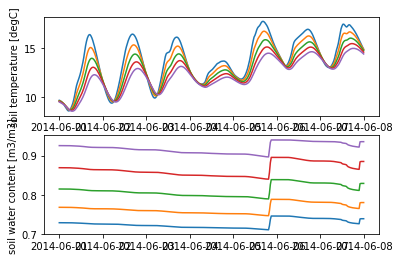

In [7]:
from tools.iotools import read_results, read_data
results = read_results(outputfile)

sim = 0  # we have only one simulation
# python indices start from 0, -1 refers to last element in array, : means 'all'
t = results.date  # time
zc = results.canopy_z  # height above ground [m]
zs = results.soil_z  # depth of soil; shown negative [m]

#%% --- soil - submodule computes soil moisture and temperature

var = ['soil_temperature', 'soil_volumetric_water_content']
lyrs = [0, 1, 2, 3, 4] # five top layers
plt.figure('soil')
k = 1
for v in var:
    plt.subplot(2,1,k)
    plt.plot(t, results[v][:,sim,lyrs])
    plt.ylabel(results[v].attrs['units'])
    k += 1